# Обучение модели классификации комментариев

**Описание проектной работы**

Интернет-магазин `«Викишоп»` запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В качестве исходных данных передан набор данных с разметкой о токсичности правок. Данные находятся в файле `toxic_comments.csv`. Столбец **text** в нём содержит текст комментария, а **toxic** — целевой признак.

**Цель проекта**

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Для оценки качества модели необходимо применить метрику качества `F1`. Значение `F1` должно быть не менее `0.75`.

**Ход  выполнения проекта**

1. Загрузка и подготовка данных.
2. Обучение моделей.
3. Анализ моделей.
4. Тестирование наилучшей модели.
3. Выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-общей-информации" data-toc-modified-id="Изучение-общей-информации-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение общей информации</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-с-помощью-логистической-регрессии" data-toc-modified-id="Обучение-с-помощью-логистической-регрессии-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение с помощью логистической регрессии</a></span></li><li><span><a href="#Обучение-модели-с-помощью-дерева-решений" data-toc-modified-id="Обучение-модели-с-помощью-дерева-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Обучение модели с помощью дерева решений</a></span></li><li><span><a href="#Обучение-модели-с-помощью-случайного-леса" data-toc-modified-id="Обучение-модели-с-помощью-случайного-леса-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение модели с помощью случайного леса</a></span></li><li><span><a href="#Обучение-с-помощью-SGDClassifier" data-toc-modified-id="Обучение-с-помощью-SGDClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обучение с помощью SGDClassifier</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Тестирование-наилучшей-модели" data-toc-modified-id="Тестирование-наилучшей-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование наилучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Изучение общей информации

[Назад к содержанию](#Содержание)

Импортируем необходимые бибилотеки и выполним настройки.

In [1]:
# импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
from tqdm.notebook import tqdm
tqdm.pandas()

import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, recall_score, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


In [2]:
# настройки

# включим возможность отображения всех столбцов в датафреймах:
pd.set_option('display.max_columns', None)

# зададим random_state:
RANDOM_STATE = 42

# определение набора стоп-слов:
nltk.download('stopwords')
stoplist = set(nltk_stopwords.words('english'))


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# чтение исходного датасета:
df = pd.read_csv('/datasets/toxic_comments.csv')
print('Датафрейм сформирован')

Датафрейм сформирован


In [4]:
# вывод первых строк датафрейма:

df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# вывод последних строк датафрейма:

df.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [6]:
# вывод общей информации о датафрейме:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Для нашей задачи признак Unnamed: 0 не потребуется, поэтому удалим его.

In [7]:
df.drop('Unnamed: 0', axis=1, inplace= True)

In [8]:
# поиск пропусков:

df.isna().sum()

text     0
toxic    0
dtype: int64

In [9]:
# поиск дубликатов:

df.duplicated().sum()

0

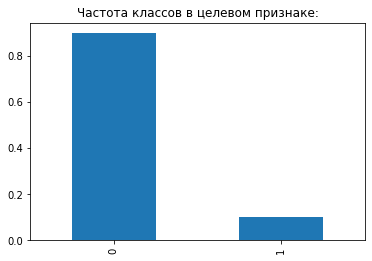

In [10]:
# подсчет классов в целевом признаке:
class_frequency = df['toxic'].value_counts(normalize=True)

# построение графика:
plt.figure()

class_frequency.plot(kind='bar');

# наименование графика:
plt.title('Частота классов в целевом признаке:')

plt.show()

In [11]:
# вывод частоты классов в целевом признаке:

print('Частота классов в целевом признаке:')
print(class_frequency)

Частота классов в целевом признаке:
0    0.898388
1    0.101612
Name: toxic, dtype: float64


Наблюдаем дисбаланс классов в целевом признаке. 

Очистим текст - оставим английские слова и пробелы. И приведем все слова к нижнему регистру.

In [12]:
# функция по чистке текста:

def clear_text(text):
    clear_text = " ".join(re.sub(r'[^a-zA-Z ]', ' ', text.lower()).split())
            
    return clear_text

In [13]:
# создание нового столбца с очищенным текстом:

df['clear_text'] = df['text'].apply(clear_text)

In [14]:
# проверка:

df.head()

,text,toxic,clear_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Создадим функции по лемматизации очищенного текста. Лемматизацию выполним с помощью библиотеки `spaCy`. Помимо лемматизации текста `spaCy` решает много других задач. Для ускорения процесса лемматизации отключим не используемые параметры `spaCy`.

In [15]:
# список не используемых параметров spaCy:
disabled_params = ['parser', 'ner']

# объект типа spaCy:
nlp = spacy.load("en_core_web_sm", disable=disabled_params)

In [16]:
# подготовка текста к лемматизации:

lemm_text = lambda text: " ".join([token.lemma_ for token in nlp(text)])

In [17]:
# создание нового столбца с лемматизированным текстом:

df['lemmas_clear'] = df['clear_text'].progress_apply(lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [18]:
# проверка:

df.head()

,text,toxic,clear_text,lemmas_clear
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [19]:
# импорт датафрейма в csv:

df.to_csv('df_lemmas.csv', index=False)

In [20]:
# загрузка датафрейма с подготовленным текстом:

df_lemmas = pd.read_csv('df_lemmas.csv')

In [21]:
# проверка:

df_lemmas.head()

,text,toxic,clear_text,lemmas_clear
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [22]:
# проверка на пропуски:

df_lemmas.lemmas_clear.isna().sum()

11

In [23]:
# вывод строк с пропусками:

df_lemmas.query('lemmas_clear.isna()')

,text,toxic,clear_text,lemmas_clear
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,NaN,NaN
6289,193.61.111.53 15:00,0,NaN,NaN
10193,"64.86.141.133""",0,NaN,NaN
17280,~ \n\n68.193.147.157,0,NaN,NaN
38743,"88.104.31.21""",0,NaN,NaN
52336,"14:53,",0,NaN,NaN
53679,92.24.199.233|92.24.199.233]],0,NaN,NaN
61644,"""\n\n 199.209.144.211 """,0,NaN,NaN
82541,"""\n '''''' 2010/2013 """,0,NaN,NaN
119018,"""""""",1,NaN,NaN


In [24]:
# удаление пропусков:

df_lemmas.dropna(subset=['lemmas_clear'], inplace=True)

In [25]:
# проверка на пропуски:

df_lemmas.lemmas_clear.isna().sum()

0

In [26]:
# поиск дубликатов:

df_lemmas.duplicated().sum()

0

Датафрейм `df_lemmas` подготовлен для обучения моделей: 

   - в качестве признаков будем использовать столбец `lemmas_clear`;
   - в качестве целевого признака - столбец `toxic`.

## Обучение

[Назад к содержанию](#Содержание)

Перед нами стоит задача бинарной классификации. Обучим различные модели и выберем среди них модель с наилучшей метрикой `F1`.

Ещё введём дополнительную метрику `recall`, т.к. важно минимизировать количество ложно-отрицательных предсказаний `FN`. 

Для решения задачи подходят следующие модели:

   - логистическая регрессия;
   - дерево решений;
   - случайные лес;
   - SGDClassifier

In [27]:
df_lemmas.head()

,text,toxic,clear_text,lemmas_clear
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [28]:
# определение признаков:

features = df_lemmas['lemmas_clear']
target = df_lemmas['toxic']

In [29]:
# разбиение признаков на обучающую и тестовую выборки:

texts_train, texts_test, target_train, target_test = \
    train_test_split(features, target, test_size=0.1, random_state=RANDOM_STATE, stratify=target)

Создадим переменные для хранения качественных метрик обученных моделей. 

In [30]:
# список с наименованиями обученных моделей:
models = []

# список для хранения значений f1:
f1_results = []

# список для хранения значений recall:
recall_results = []

Создадим функцию `get_model` для обучения моделей и подбора гиперпараметров. Для подбора гиперпараметров используем `GridSearchCV`. Количество фолдов возьмем `3`, в связи с большой выборкой. 

Для обучения моделей сперва необходимо векторизовать обучающую выборку. Поскольку `GridSearchCV` использует крос-валидацию, то векторизовать всю обучающую выборку было бы не верным, т.к. при кросс-валидации выборка будет разделена на обучающую и валидационную. Если выполнить векторизацию всей обучающей выборки, то будет утечка данных в валидационную выборку при кросс-валидации. Для избежания векторизовать выборку будем с помощью `Pipeline`, который будет состоять из векторайзера и обучаемой модели.


In [31]:
# создаём функцию для обучения моделей и подбора гиперпараметров:

def get_model(model, parameters, model_name):
    
    pipe = Pipeline([('vct', TfidfVectorizer(stop_words=stoplist)),
                 ('clf', model)])
    
    params = parameters
    
    search_model = GridSearchCV( \
                pipe,
                params,
                scoring={'f1', 'recall'},
                refit='f1',
                cv=3,
                n_jobs=-1,
                verbose=1)
    
    # обучение модели с помощью кросс-валидации:
    search_model.fit(texts_train, target_train)
    
    # F1 на кросс-валидации:
    search_f1 = search_model.best_score_
    print('f1 на кросс-валидации:', search_f1)
    
    # recall на кросс-валидации:          
    search_recall = search_model.cv_results_['mean_test_recall'].mean()
    print('Среднее значение recall на кросс-валидации:', search_recall)
       
    # лучшие найденные гиперпараметры:
    search_params = search_model.best_params_
    print('Наилучшие гиперпараметры модели:', search_params)
    
    # сохранение результатов:
    models.append(model_name)
    f1_results.append(search_f1)
    recall_results.append(search_recall)
    
    return search_model, search_f1, search_recall, search_params


### Обучение с помощью логистической регрессии

[Назад к содержанию](#Содержание)

In [32]:
%%time

# задание параметров для LogisticRegression:
lgr_params = {'clf__C': [9, 10, 11, 12, 13]}

# создание объекта типа LogisticRegression:
lgr = LogisticRegression( \
                C=1.0,
                class_weight='balanced',
                max_iter=1000,
                n_jobs=-1,
                random_state=RANDOM_STATE, 
                solver='lbfgs',
                verbose=0)

# поиск модели с оптимальными гиперпараметрами
# и расчет метрик с помощью кросс-валидации:
search_lgr, f1_lgr, recall_lgr, params_lgr = get_model(lgr, lgr_params, 'LogisticRegression') 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
f1 на кросс-валидации: 0.7629018273011852
Среднее значение recall на кросс-валидации: 0.8155431313698577
Наилучшие гиперпараметры модели: {'clf__C': 10}
CPU times: user 15min 56s, sys: 15min 38s, total: 31min 35s
Wall time: 31min 45s


### Обучение модели с помощью дерева решений

[Назад к содержанию](#Содержание)

In [33]:
%%time

# задание параметров для DecisionTreeClassifier:

dtc_parameters = { \
                  'clf__max_features': ['auto', 'sqrt', 'log2'],
                  'clf__ccp_alpha': [0.1, .01, .001],
                  'clf__max_depth' : [5, 6, 7, 8, 9],
                  'clf__criterion' : ['gini', 'entropy']
             }

# создание объекта типа DecisionTreeClassifier:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

# поиск модели с оптимальными гиперпараметрами и расчет f1:
search_dtc, f1_dtc, recall_dtc, params_dtc = get_model(dtc, dtc_parameters, 'DecisionTreeClassifier') 


Fitting 3 folds for each of 90 candidates, totalling 270 fits
f1 на кросс-валидации: 0.20303258212620032
Среднее значение recall на кросс-валидации: 0.748337945391646
Наилучшие гиперпараметры модели: {'clf__ccp_alpha': 0.001, 'clf__criterion': 'gini', 'clf__max_depth': 9, 'clf__max_features': 'auto'}
CPU times: user 30min 12s, sys: 23.3 s, total: 30min 35s
Wall time: 30min 37s


### Обучение модели с помощью случайного леса

[Назад к содержанию](#Содержание)

In [34]:
%%time

# задание параметров для RandomForestClassifier:

rfc_params = { 
    'clf__n_estimators': [200, 500],
    'clf__max_features': ['auto', 'log2'],
    'clf__max_depth' : [4, 5, 6],
    'clf__criterion' : ['gini', 'entropy']
}

# создание объекта типа RandomForestClassifier:
rfc = RandomForestClassifier( \
        random_state=RANDOM_STATE,
        class_weight='balanced')

# поиск модели с оптимальными гиперпараметрами и расчет f1:
search_rfc, f1_rfc, recall_rfc, params_rfc = get_model(rfc, rfc_params, 'RandomForestClassifier')

Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1 на кросс-валидации: 0.35243529363616505
Среднее значение recall на кросс-валидации: 0.8469726745677738
Наилучшие гиперпараметры модели: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__max_features': 'auto', 'clf__n_estimators': 200}
CPU times: user 17min 16s, sys: 6.98 s, total: 17min 23s
Wall time: 17min 24s


### Обучение с помощью SGDClassifier

[Назад к содержанию](#Содержание)

In [35]:
%%time

sgd_params = {
    "clf__loss" : ["hinge", "log", "squared_hinge"],
    "clf__alpha" : [0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "none"],
}

sgd = SGDClassifier( \
    random_state = RANDOM_STATE,
    class_weight='balanced')

search_sgd, f1_sgd, recall_sgd, params_sgd = get_model(sgd, sgd_params, 'SGDClassifier')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
f1 на кросс-валидации: 0.71569935168032
Среднее значение recall на кросс-валидации: 0.6540563622075602
Наилучшие гиперпараметры модели: {'clf__alpha': 0.001, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}
CPU times: user 10min 16s, sys: 10.3 s, total: 10min 26s
Wall time: 10min 27s


## Анализ моделей

[Назад к содержанию](#Содержание)

Выведем полученные метрики в таблицу.

In [36]:
# таблица с полученными результатами:
results = (pd.DataFrame({
                        'Model':models,
                        'F1 score':f1_results,
                        'Recall': recall_results,
                        }).sort_values(by='F1 score', ascending=False).
                              reset_index(drop=True))

# вывод результатов:
results

,Model,F1 score,Recall
0,LogisticRegression,0.762902,0.815543
1,SGDClassifier,0.715699,0.654056
2,RandomForestClassifier,0.352435,0.846973
3,DecisionTreeClassifier,0.203033,0.748338


Из полученных результатов `F1` и `recall` на обучающей выборке можно сделать вывод, что наилучшей моделью является модель, обученная с помощью `логистической регресии`.

Далее заново обучим логистическую регрессию с найденными оптимальными гиперпараметрами и протестируем на тестовой выборке.

In [54]:
# создание векторайзера TF-IDF:
vect_word = TfidfVectorizer(
                    ngram_range=(1,3),
                    min_df=3,
                    max_df=0.9,
                    use_idf=1,
                    smooth_idf=1,
                    sublinear_tf=1,
                    stop_words=stoplist)

# преобразование выборок:
X_train = vect_word.fit_transform(texts_train)
X_test = vect_word.transform(texts_test)

In [55]:
%%time

# обучение логистической регрессии с оптимальными гиперпараметрами:
lgr_optimal = LogisticRegression(
                        C = params_lgr['clf__C'],
                        class_weight='balanced',    
                        random_state=RANDOM_STATE)
lgr_optimal.fit(X_train, target_train)

CPU times: user 26.4 s, sys: 20.8 s, total: 47.3 s
Wall time: 47.4 s


LogisticRegression(C=10, class_weight='balanced', random_state=42)

## Тестирование наилучшей модели

[Назад к содержанию](#Содержание)

Далее выполним предсказания наилучшей модели на тестовой выборке.

In [57]:
# предсказания логистической регрессии на тестовой выборке:
predicted = lgr_optimal.predict(X_test)

# вычисление f1-меры:
f1 = f1_score(target_test, predicted)
print('F1 логистической регрессии на тестовой выборке:', f1)

# вычисление recall:
recall = recall_score(target_test, predicted)
print('Recall логистической регрессии на тестовой выборке:', recall)

F1 логистической регрессии на тестовой выборке: 0.7932591032199819
Recall логистической регрессии на тестовой выборке: 0.81408276714021


Построим `ROC-кривую` для наилучшей модели и вычислим значение `AUC-ROC`.

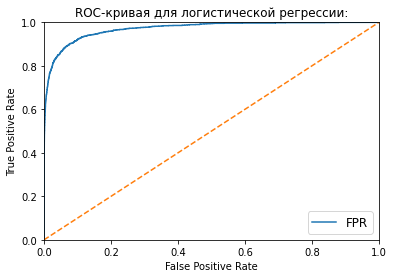

AUC-ROC для логистической регрессии: 0.9710695061138498


In [61]:
# вероятности положительного класса:
probabilities_test_lgr = lgr_optimal.predict_proba(X_test)
probabilities_one_test_lgr = probabilities_test_lgr[:, 1]

# вычисление значений FPR, TPR и рассмотренные пороги:
fpr_lgr, tpr_lgr, thresholds_lgr = roc_curve(target_test, probabilities_one_test_lgr)

# построение графика:
plt.figure()

plt.plot(fpr_lgr, tpr_lgr, label='FPR')


# ROC-кривая случайной модели:
plt.plot([0, 1], [0, 1], linestyle='--')

# установка границ осей от 0 до 1:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# подпись осей "False Positive Rate" и "True Positive Rate":
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# заголовок "ROC-кривая":
plt.title('ROC-кривая для логистической регрессии:')

plt.legend(fontsize='large')

plt.show()

# вывод AUC-ROC значения:
auc_roc = roc_auc_score(target_test, probabilities_one_test_lgr)
print(f'AUC-ROC для логистической регрессии:', auc_roc)

## Выводы

[Назад к содержанию](#Содержание)

В данной работе разработали инструмент для интернет-магазина `Викишоп`, позволяющий классифицировать комментарии пользователей на негативные и позитивные. Под инструментом подразумевается модель машинного обучения. 

В качестве исходных данных был предоставлен датасет из порядка 160 тысяч твитов. Датасет был предоставлен с размеченными данными - каждому твиту был присвоен свой класс - `0` (положительный комментарий) или `1` (негативный). Эти данные использовали для обучения нескольких моделей. Были смоделированы следующие модели:

   - логистическая регрессия;
   - дерево решений;
   - случайный лес;
   - SGDClassifier.
   
Лучше всех себя проявила `логистическая регрессия`. Поэтому в качестве наилучшей модели была выбрана именно эта модель. 

Заданная метрика `F1` наилучшей модели составила более заданного минимального значения `0.75` и составляет:


In [62]:
f1

0.7932591032199819

Также логистическая регрессия показала отличное значение `AUC-ROC`:

In [63]:
auc_roc

0.9710695061138498